In [9]:
from huggingface_hub import hf_hub_download
import torch
from torchvision import transforms
from PIL import Image 

#### **loading the model**

In [5]:
model_path = hf_hub_download(
    repo_id= "dudeawsome0me/Intell_detection_model",
    filename= "model_scripted.pt"
)

In [6]:
model = torch.jit.load(model_path,map_location="cpu")

#### **Preprocessing function**

In [ ]:
def image_processing(image_path):
    """
    this function applies the following transformations :
        - Resizing the image
        - Transfrom it to Tensor 
        - Turnning the image to a 3 channel matrix
        - Normalizing the image 
    """
    transform = transforms.Compose([
        transforms.Resize((150,150)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3,std=[0.5]*3)
        ])
    img = Image.open(image_path).convert("RGB")

    tensor_input = transform(img).unsqueeze(0)
    return tensor_input
    


In [21]:
img_path = "/home/yassine/projects/Intel_detection_Fast_API/test/forest.jpg"
t = image_processing(img_path)
t.shape

torch.Size([1, 3, 150, 150])

In [46]:
class img_classifier():
    def __init__(self,model,img_path):
        self.model = model
        self.path = img_path
        self.class_list = ["buildings","forest","glacier","mountain","sea","street"]

    def image_processing(self):
        """
        this function applies the following transformations :
            - Resizing the image
            - Transfrom it to Tensor 
            - Turnning the image to a 3 channel matrix
            - Normalizing the image 
        """
        transform = transforms.Compose([
            transforms.Resize((150,150)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3,std=[0.5]*3)
            ])
        img = Image.open(self.path).convert("RGB")

        tensor_input = transform(img).unsqueeze(0)
        return  tensor_input

    def inference(self,tensor_input):
        with torch.inference_mode():
            classes = self.model(tensor_input)
            _,predicted = torch.max(classes,1)
            label = self.class_list[predicted.item()]
        return label
    
    def workflow(self):
        tensor_input = self.image_processing()
        result = self.inference(tensor_input)
        return result

In [ ]:
img_path = "/home/yassine/projects/Intel_detection_Fast_API/test/forest.jpg"
clf = img_classifier(model,img_path)
result = clf.workflow()
print(result)

["buildings","forest","glacier","mountain","sea","street"]

the predicted class is : forest


In [41]:
import pandas as pd
dir_path = "/home/yassine/projects/Intel_detection_Fast_API/test"
img_paths = [os.path.join(dir_path,f) for f in os.listdir(dir_path)] 
labels = ["glacier","buildings","forest","sea"]
test_df = pd.DataFrame({
    "img_path":img_paths,
    "class":labels
})

test_df

,img_path,class
0,/home/yassine/projects/Intel_detection_Fast_AP...,glacier
1,/home/yassine/projects/Intel_detection_Fast_AP...,buildings
2,/home/yassine/projects/Intel_detection_Fast_AP...,forest
3,/home/yassine/projects/Intel_detection_Fast_AP...,sea


In [47]:
CLS = img_classifier(model,img_path=None)
def unit_inference_for_df(img_path):
    CLS.path = img_path   # change only the path
    return CLS.workflow()

test_df['class_pred'] = test_df["img_path"].apply(lambda x : unit_inference_for_df(x))

In [48]:
test_df

,img_path,class,class_pred
0,/home/yassine/projects/Intel_detection_Fast_AP...,glacier,sea
1,/home/yassine/projects/Intel_detection_Fast_AP...,buildings,street
2,/home/yassine/projects/Intel_detection_Fast_AP...,forest,forest
3,/home/yassine/projects/Intel_detection_Fast_AP...,sea,sea


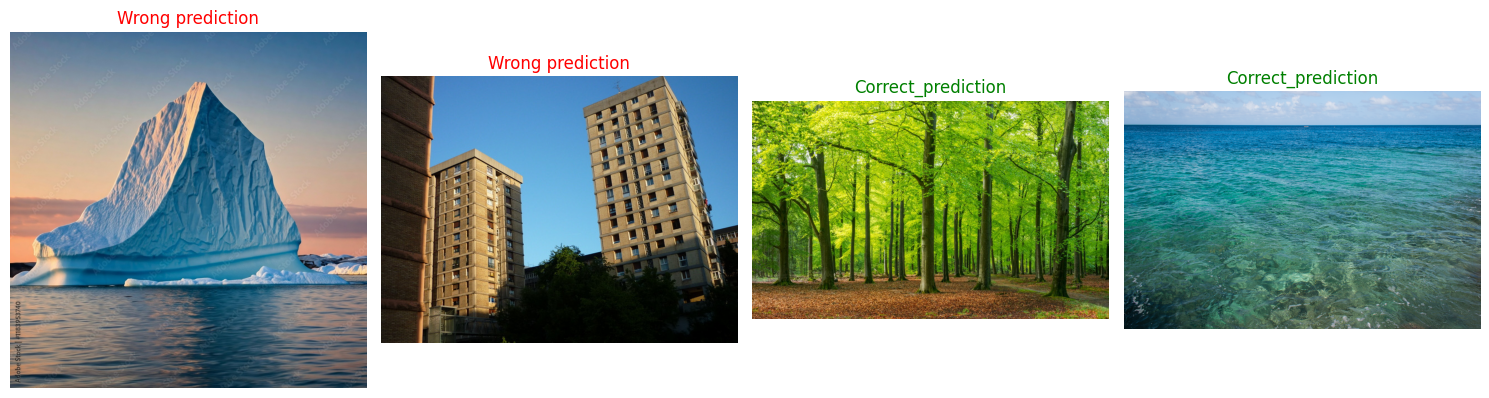

In [53]:
import matplotlib.pyplot as plt 

fig , ax = plt.subplots(1,4,figsize=(15,5))
ax = ax.flatten()

for i in range(0,len(test_df)):
    ax[i].imshow(Image.open(test_df.iloc[i,0]))
    if test_df.iloc[i,1] == test_df.iloc[i,2] :
        ax[i].set_title('Correct_prediction',c='g')
    else:
        ax[i].set_title('Wrong prediction',c='r')
    ax[i].axis('off')

plt.tight_layout()
